
Perceptron test to demonstrate hypothesized non-linearity of data
---



The following is our implementation of a Perceptron, using `sklearn`. The structure for the perceptron follows, and the execution code follows (ctrl+f: main runner.)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Perceptron
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump
from tqdm.auto import tqdm

In [ ]:
def train_perceptron_with_feature_selection(X, y):
    """
    trains a Perceptron; uses feature selection and trains with all max_iter values
    """
    print("Processing features...")
    imputer = SimpleImputer(strategy='mean')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    class_counts = y.value_counts()
    print("original class distribution:")
    print(class_counts)

    def group_decades(decade):
        if decade < 1950:
            return 1940  # all pre-1950 are "1940s and earlier"
        elif 1950 <= decade < 1970:
            return 1960  # 50/60s together
        elif 1970 <= decade < 1990:
            return 1980  # 70/80s together
        else:
            return decade

    y_grouped = y.apply(group_decades)

    small_classes = class_counts[class_counts < 2].index.tolist()
    if small_classes:
        print(f"removing {len(small_classes)} decades with fewer than 2 samples: {small_classes}")
        valid_samples = ~y_grouped.isin(small_classes)
        X_filtered = X_imputed[valid_samples]
        y_filtered = y_grouped[valid_samples]
    else:
        X_filtered = X_imputed
        y_filtered = y_grouped

    print("after grouping, class distribution is:")
    print(y_filtered.value_counts())

    print("Now splitting data into training and test sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_filtered, y_filtered,
        test_size=0.2,
        random_state=42,
        stratify=y_filtered
    )

    print("Finding best feature selection values...")
    k_values = [50, 100, 200, 300]
    k_results = []

    with tqdm(total=len(k_values), desc="Initial Feature Selection") as pbar:
        for k in k_values:
            selector = SelectKBest(f_classif, k=k)

            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('feature_selection', selector),
                ('perceptron', Perceptron(max_iter=1000, tol=1e-3, class_weight='balanced', random_state=42))
            ])

            start_time = time.time()
            pipeline.fit(X_train, y_train)
            train_time = time.time() - start_time

            train_score = pipeline.score(X_train, y_train)
            test_score = pipeline.score(X_test, y_test)

            k_results.append({
                'k': k,
                'train_score': train_score,
                'test_score': test_score,
                'train_time': train_time
            })

            pbar.set_postfix({
                'k': k,
                'train_acc': f"{train_score:.4f}",
                'test_acc': f"{test_score:.4f}",
                'time': f"{train_time:.2f}s"
            })
            pbar.update(1)

    best_k = max(k_results, key=lambda x: x['test_score'])['k']
    print(f"Best initial k: {best_k} features")

    print("Training and testing models with all max iteration values...")
    iter_values = [5,10,15,20,25,30,35,40, 60, 100]
    all_models = []
    all_results = []

    with tqdm(total=len(iter_values), desc="Training perceptron model with various maximum iterations") as pbar:
        for max_iter in iter_values:
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(f_classif, k=best_k)),
                ('perceptron', Perceptron(max_iter=max_iter, tol=1e-3, class_weight='balanced', random_state=42))
            ])

            start_time = time.time()
            pipeline.fit(X_train, y_train)
            train_time = time.time() - start_time

            train_score = pipeline.score(X_train, y_train)
            test_score = pipeline.score(X_test, y_test)
            y_pred = pipeline.predict(X_test)

            result = {
                'max_iter': max_iter,
                'train_score': train_score,
                'test_score': test_score,
                'train_time': train_time
            }

            all_results.append(result)
            all_models.append(pipeline)

            print(f"\nResults for max_iter={max_iter}:")
            print(f"Training accuracy: {train_score:.4f}")
            print(f"Test accuracy: {test_score:.4f}")
            print(f"Training time: {train_time:.2f}s")

            print("\nClassification Report:")
            print(classification_report(y_test, y_pred))

            conf_matrix = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                        xticklabels=sorted(np.unique(y_test)),
                        yticklabels=sorted(np.unique(y_test)))
            plt.xlabel('Predicted Decade')
            plt.ylabel('True Decade')
            plt.title(f'Confusion Matrix - Perceptron (max_iter={max_iter})')
            plt.tight_layout()
            plt.savefig(f'perceptron_confusion_matrix_iter_{max_iter}.png')

            pbar.update(1)

    print("\nSummary of all models:")
    results_df = pd.DataFrame(all_results)
    print(results_df)

    plt.figure(figsize=(10, 6))
    plt.plot(results_df['max_iter'], results_df['test_score'], 'o-', label='Test Accuracy')
    plt.plot(results_df['max_iter'], results_df['train_score'], 'o-', label='Train Accuracy')
    plt.xscale('log')
    plt.xlabel('max_iter (log scale)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs max_iter for Perceptron')
    plt.legend()
    plt.grid(True)
    plt.savefig('perceptron_accuracy_vs_iter.png')

    plt.figure(figsize=(10, 6))
    plt.plot(results_df['max_iter'], results_df['train_time'], 'o-')
    plt.xscale('log')
    plt.xlabel('max_iter (log scale)')
    plt.ylabel('Training Time (s)')
    plt.title('Training Time vs max_iter for Perceptron')
    plt.grid(True)
    plt.savefig('perceptron_time_vs_iter.png')

    return all_models, all_results[-1]['train_score'], all_results[-1]['test_score'], k_results, all_results


In [ ]:
def visualize_perceptron_decision_boundary(model, X, y):

    from sklearn.decomposition import PCA

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X_scaled)

    class_counts = y.value_counts()
    valid_classes = class_counts[class_counts > 1].index
    X_2d = X_2d[y.isin(valid_classes)]
    y = y[y.isin(valid_classes)]

    #limits to 20 pts to plot
    X_plot = []
    y_plot = []
    for decade in np.unique(y):
        indices = np.where(y == decade)[0]
        num_samples = min(len(indices), 20)
        selected_indices = np.random.choice(indices, size=num_samples, replace=False)
        X_plot.extend(X_2d[selected_indices])
        y_plot.extend(y[selected_indices])

    X_plot = np.array(X_plot)
    y_plot = np.array(y_plot)

    X_train, X_test, y_train, y_test = train_test_split(
        X_2d, y, test_size=0.2, random_state=42, stratify=y
    )

    perceptron_2d = Perceptron(max_iter=2000, tol=1e-3, class_weight='balanced', random_state=42)
    perceptron_2d.fit(X_train, y_train)


    train_accuracy = perceptron_2d.score(X_train, y_train)
    test_accuracy = perceptron_2d.score(X_test, y_test)

    print(f"2D Perceptron Training Accuracy: {train_accuracy:.4f}")
    print(f"2D Perceptron Test Accuracy: {test_accuracy:.4f}")

    h = 0.02
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    plt.figure(figsize=(12, 10))

    Z = perceptron_2d.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.coolwarm)

    decades = sorted(np.unique(y))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(decades)))

    for decade, color in zip(decades, colors):
        idx = y_plot == decade
        plt.scatter(X_plot[idx, 0], X_plot[idx, 1], c=[color],
                    label=f'{int(decade)}s', edgecolor='black', alpha=0.6)

    plt.title('Perceptron decision boundaries (projected onto 2D)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.tight_layout()
    plt.savefig('perceptron_decision_boundaries.png')

    return train_accuracy, test_accuracy

Main runner:

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive/', force_remount=True)
# TODO for graders: Set this path string to match the directory at the root of this project.
os.chdir('/content/drive/MyDrive/Final Project')

Mounted at /content/drive/


In [ ]:
features_path = 'fma_metadata/features.csv'
tracks_path = 'fma_metadata/tracks.csv'

print("Loading and preparing data...")
X, y = load_and_prepare_data(features_path, tracks_path)

Loading and preparing data...
Loading features data...
Loading tracks data...


<ipython-input-16-ae7df0711794>:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tracks_df['year'] = pd.to_datetime(tracks_df['album.2'], errors='coerce').dt.year


Merging datasets...
Total samples: 47825
Number of features: 518
Decade distribution: decade
1900        3
1910        6
1930        1
1960       17
1970       34
1980      246
1990     1251
2000    17312
2010    28955
Name: count, dtype: int64


Processing features...
original class distribution:
decade
2010    28955
2000    17312
1990     1251
1980      246
1970       34
1960       17
1910        6
1900        3
1930        1
Name: count, dtype: int64
removing 1 decades with fewer than 2 samples: [1930]
after grouping, class distribution is:
decade
2010    28955
2000    17312
1990     1251
1980      280
1960       17
1940       10
Name: count, dtype: int64
Now splitting data into training and test sets...
Finding best feature selection values...


Initial Feature Selection:   0%|          | 0/4 [00:00<?, ?it/s]

Best initial k: 300 features
Training and testing models with all max iteration values...


Training perceptron model with various maximum iterations:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(



Results for max_iter=5:
Training accuracy: 0.3536
Test accuracy: 0.3470
Training time: 1.88s

Classification Report:
              precision    recall  f1-score   support

        1940       0.00      0.00      0.00         2
        1960       0.00      0.00      0.00         4
        1980       0.01      0.20      0.02        56
        1990       0.03      0.12      0.05       250
        2000       0.37      0.30      0.33      3462
        2010       0.63      0.39      0.48      5791

    accuracy                           0.35      9565
   macro avg       0.17      0.17      0.15      9565
weighted avg       0.52      0.35      0.41      9565



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(



Results for max_iter=10:
Training accuracy: 0.3359
Test accuracy: 0.3266
Training time: 2.85s

Classification Report:
              precision    recall  f1-score   support

        1940       0.00      0.00      0.00         2
        1960       0.00      0.00      0.00         4
        1980       0.01      0.20      0.02        56
        1990       0.03      0.24      0.05       250
        2000       0.36      0.23      0.28      3462
        2010       0.63      0.39      0.48      5791

    accuracy                           0.33      9565
   macro avg       0.17      0.18      0.14      9565
weighted avg       0.51      0.33      0.39      9565



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(



Results for max_iter=15:
Training accuracy: 0.3455
Test accuracy: 0.3370
Training time: 3.70s

Classification Report:
              precision    recall  f1-score   support

        1940       0.00      1.00      0.00         2
        1960       0.00      0.00      0.00         4
        1980       0.01      0.18      0.02        56
        1990       0.03      0.10      0.05       250
        2000       0.34      0.16      0.21      3462
        2010       0.62      0.46      0.53      5791

    accuracy                           0.34      9565
   macro avg       0.17      0.32      0.14      9565
weighted avg       0.50      0.34      0.40      9565


Results for max_iter=20:
Training accuracy: 0.3819
Test accuracy: 0.3761
Training time: 4.02s

Classification Report:
              precision    recall  f1-score   support

        1940       0.00      0.50      0.01         2
        1960       0.00      0.00      0.00         4
        1980       0.01      0.18      0.02        56
  

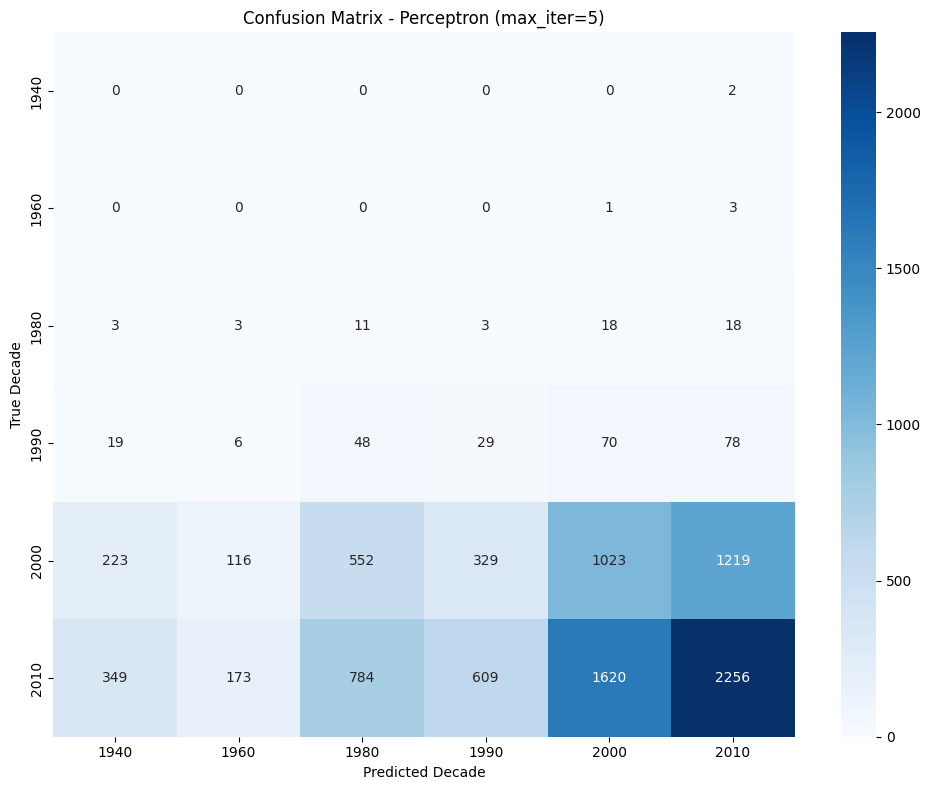

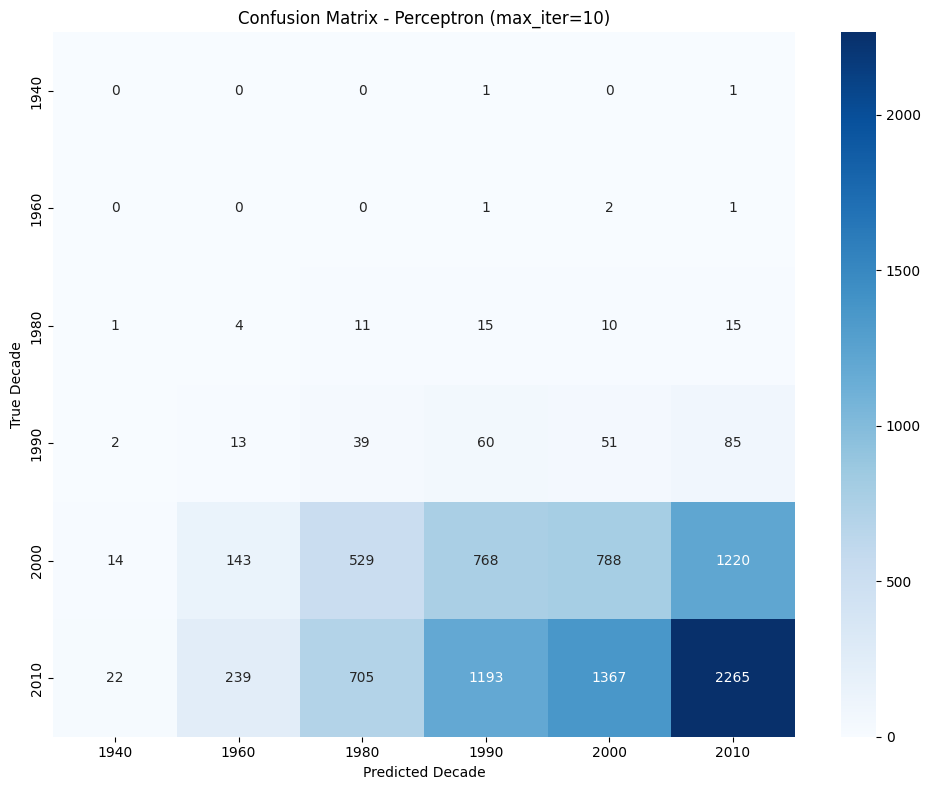

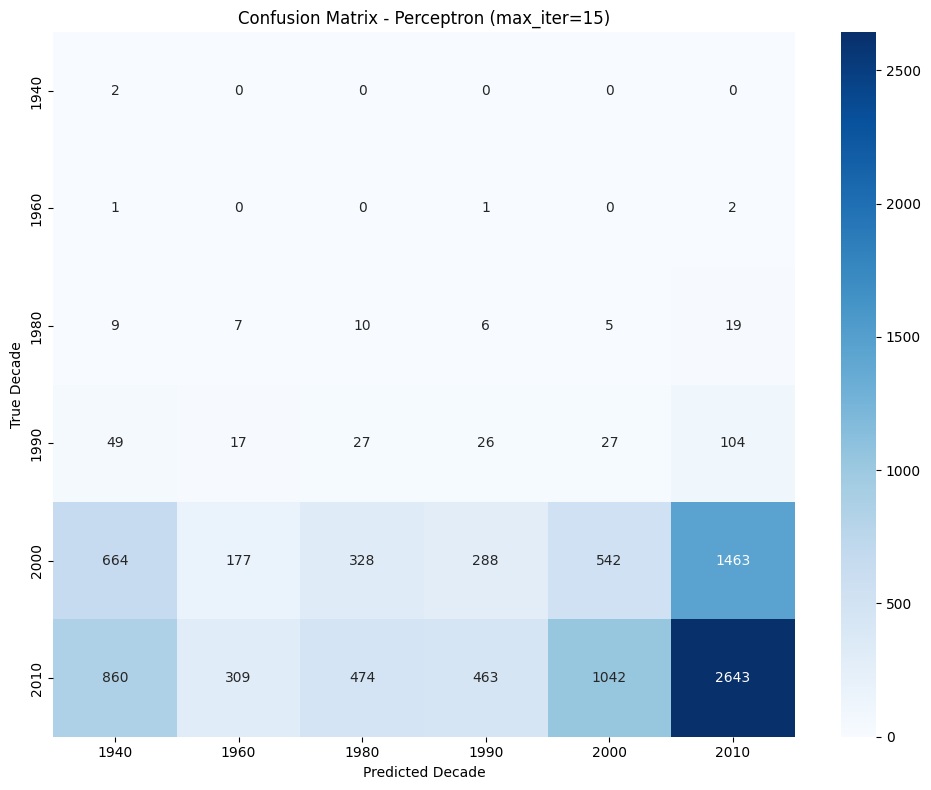

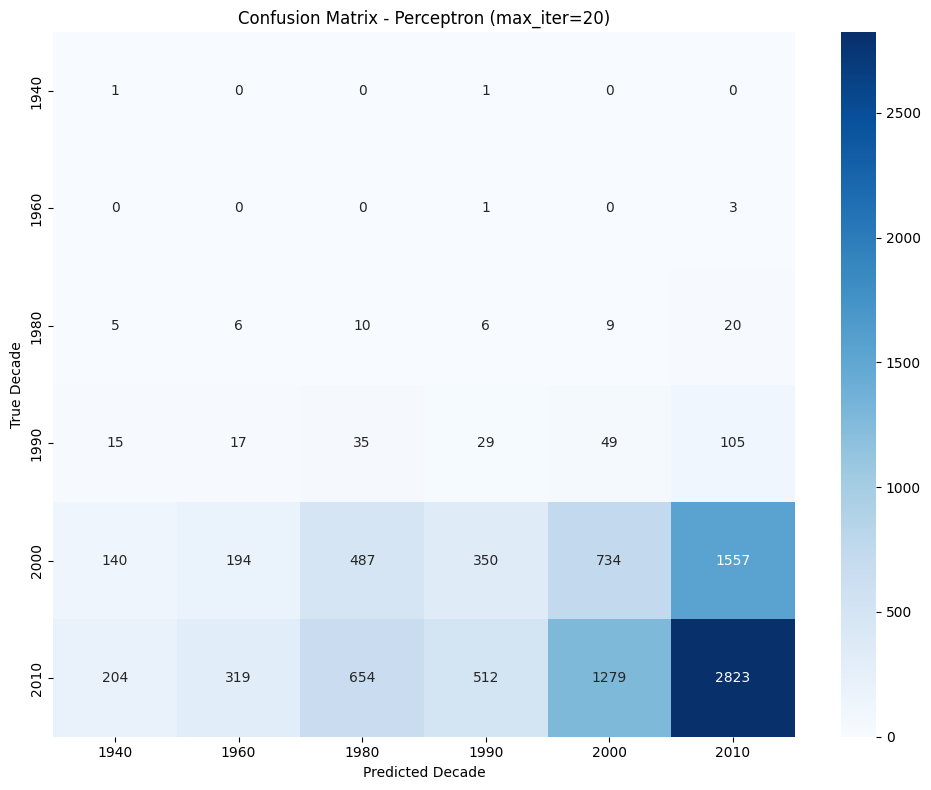

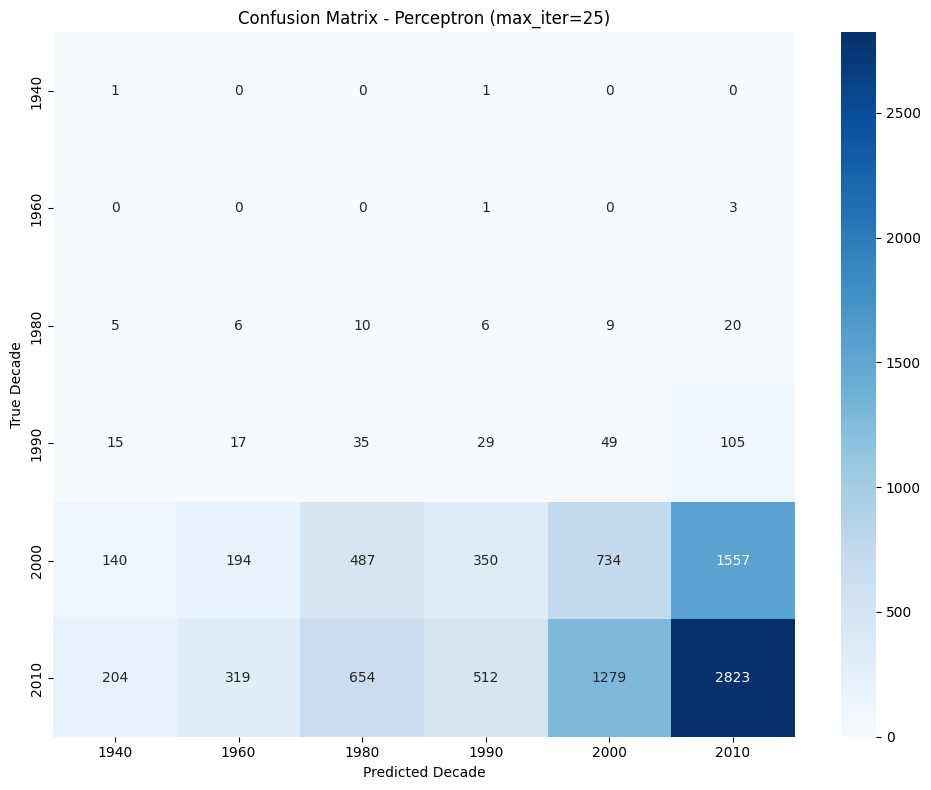

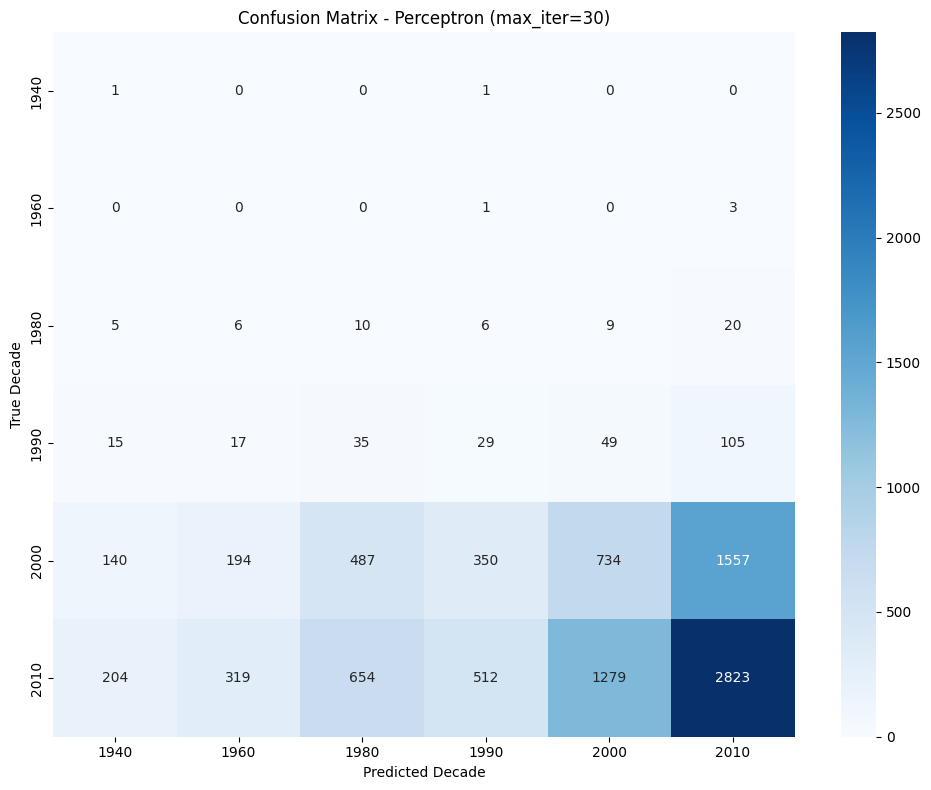

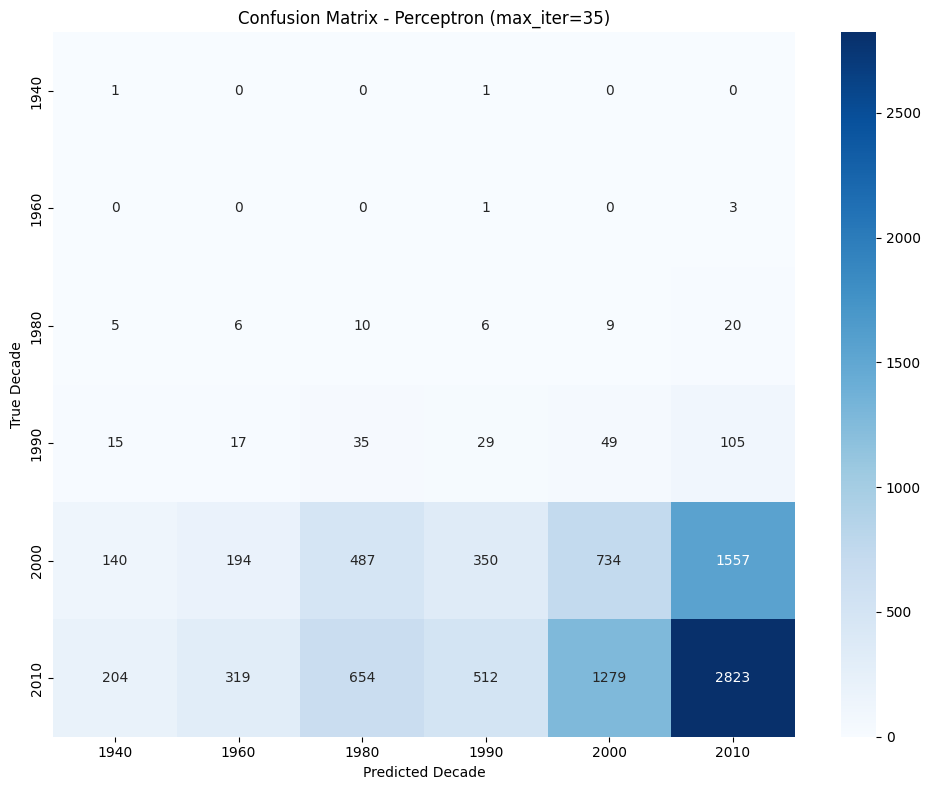

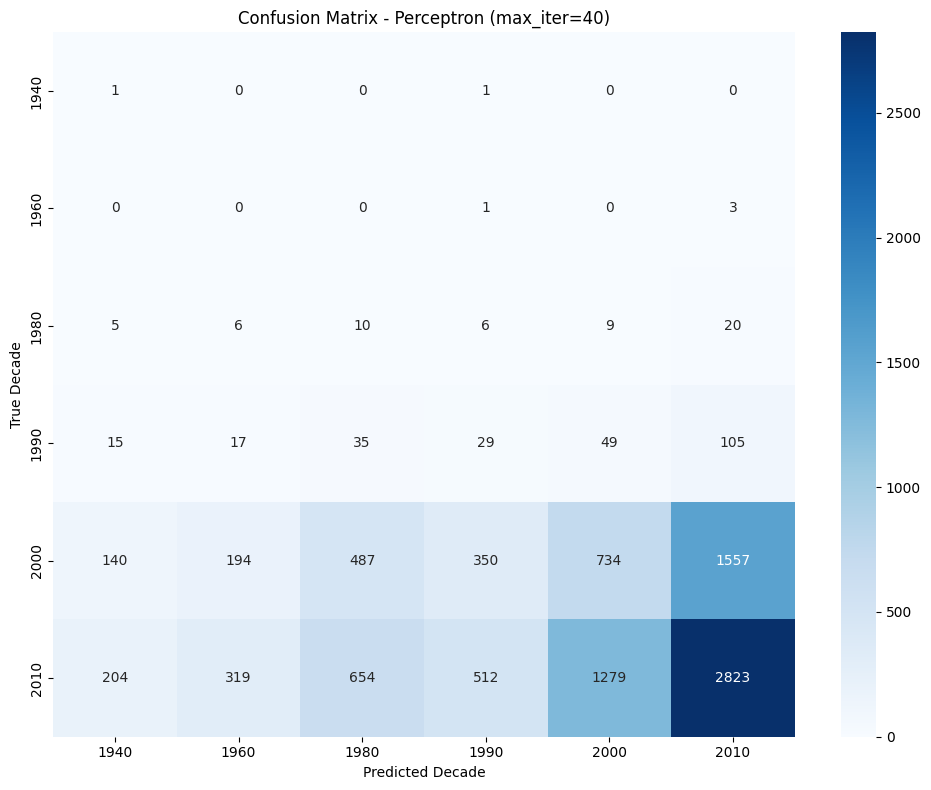

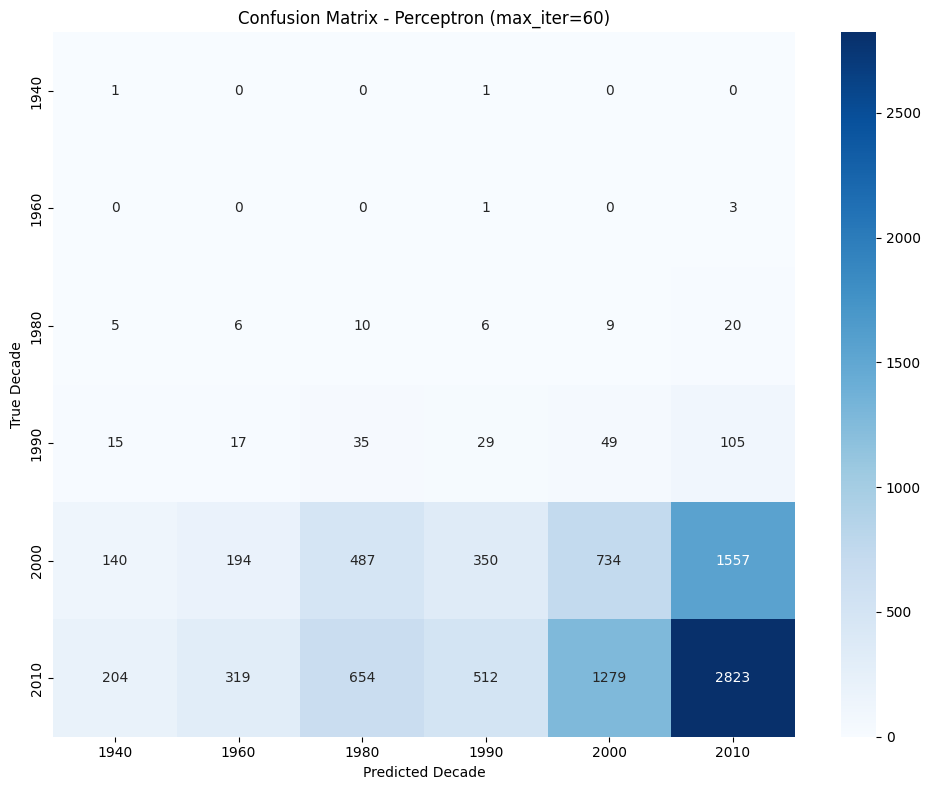

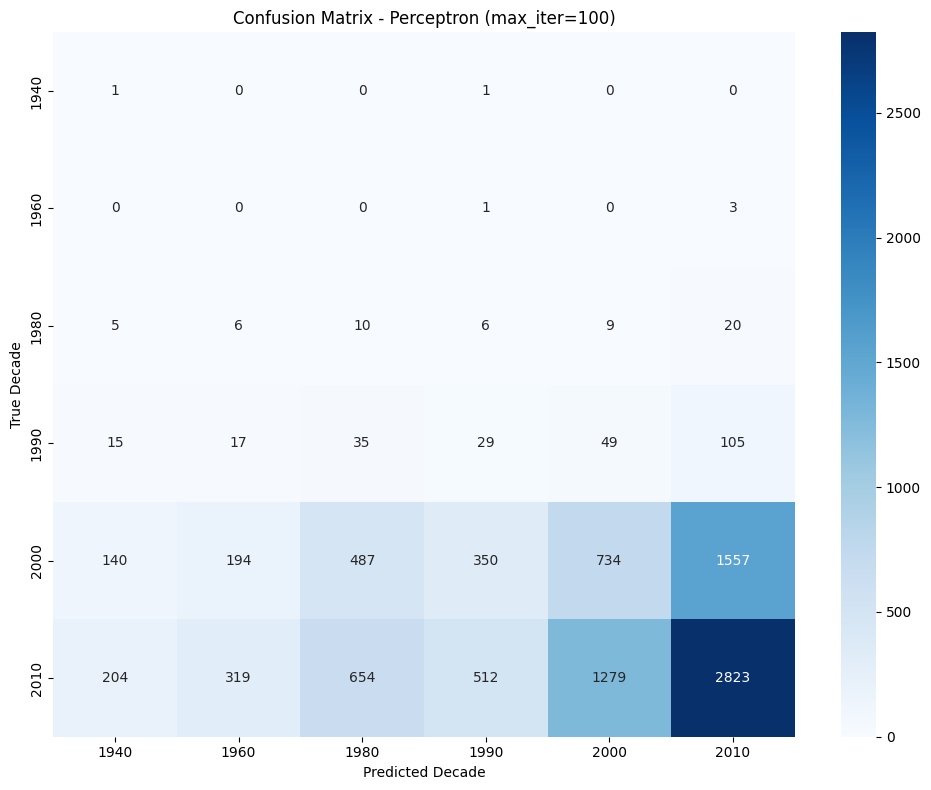

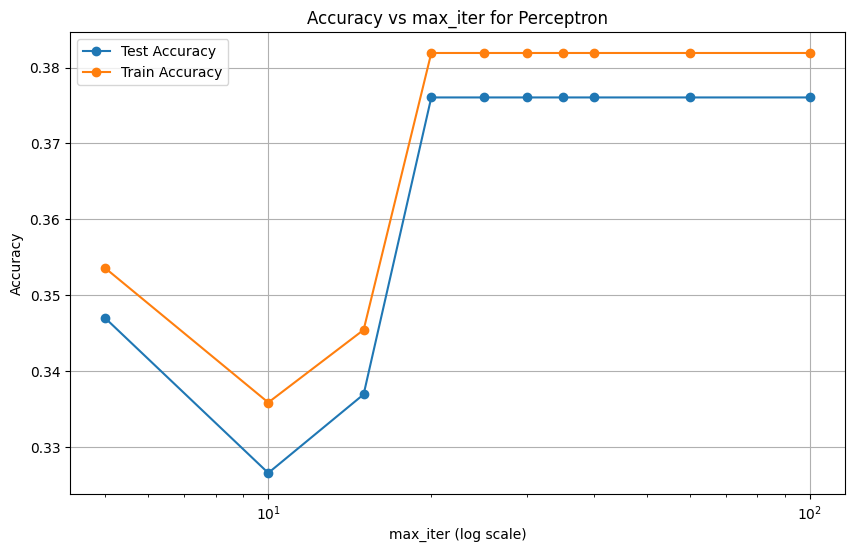

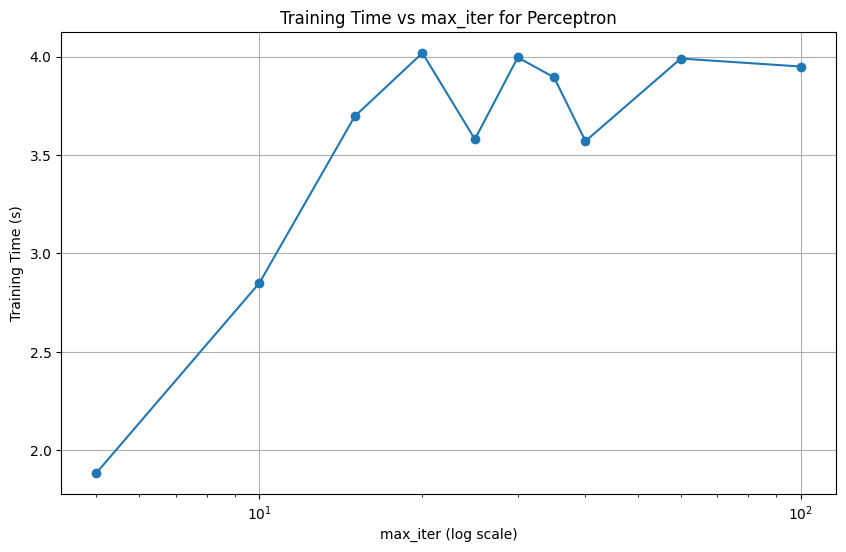

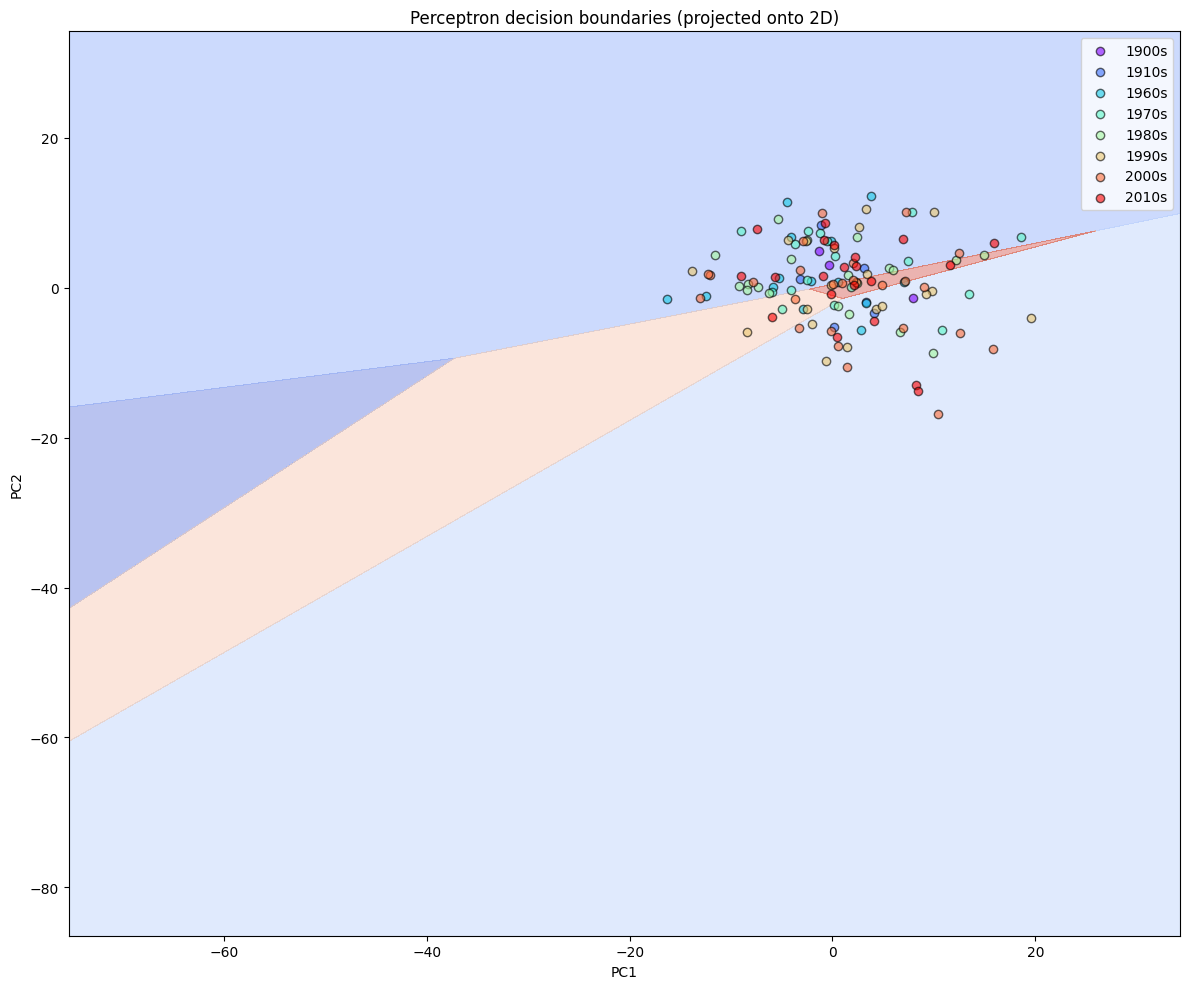

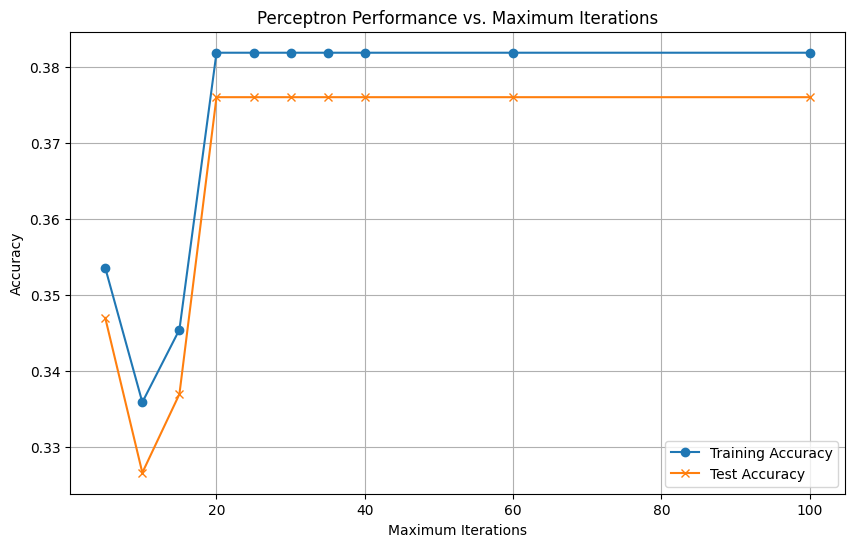

In [ ]:
perceptron_model, train_acc, test_acc, k_results, iter_results = train_perceptron_with_feature_selection(X, y)

dump(perceptron_model, 'perceptron_model.joblib')
print("Perceptron model saved as 'perceptron_model.joblib'")

print("\nVisualizing Perceptron decision boundaries...")
viz_train_acc, viz_test_acc = visualize_perceptron_decision_boundary(perceptron_model, X, y)

print("\nAnalysis complete!")
print(f"Perceptron final accuracy: {test_acc:.4f}")
print(f"2D Perceptron accuracy: {viz_test_acc:.4f}")
print("The low accuracy of the Perceptron model demonstrates that")
print("the music decade classification data is not linearly separable.")

iter_df = pd.DataFrame(iter_results)
print("\nEffect of increasing iterations:")
print(iter_df[['max_iter', 'train_score', 'test_score']])

plt.figure(figsize=(10, 6))
plt.plot(iter_df['max_iter'], iter_df['train_score'], marker='o', label='Training Accuracy')
plt.plot(iter_df['max_iter'], iter_df['test_score'], marker='x', label='Test Accuracy')
plt.xlabel('Maximum Iterations')
plt.ylabel('Accuracy')
plt.title('Perceptron Performance vs. Maximum Iterations')
plt.legend()
plt.grid(True)
plt.savefig('perceptron_iterations.png')
print("Saved iteration analysis plot to 'perceptron_iterations.png'")